The aim of this project is to label data into different igneous rock classes and build a k nearest neighbors classification model.  

In [8]:
import pandas as pd

desc_df = pd.read_csv('tblRockGeoData.txt')
major_df = pd.read_csv('xtbMajorChem.txt')
trace_df = pd.read_csv('xtbEsChem.txt')

trace_df = trace_df[trace_df.columns.drop(list(trace_df.filter(regex='[A-Za-z]*_sq')))]
major_df.dropna(axis=1, how='all', inplace=True)
major_df = major_df.filter(regex='^\w*(xrf|org_dff|crb_ttr|tot_cmb)$')



Major and minor elements are cleaned and formatted so that we can work with them.  Next step is to start geochemical discrimination plots.

<Figure size 1600x1600 with 0 Axes>

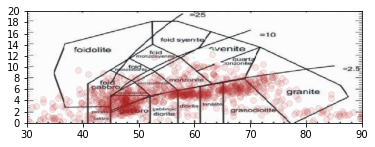

<Figure size 1600x1600 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt

tas_img = plt.imread(r'/Users/michaelspehlmann/Documents/rock classer/Plutonic TAS.png')

major_df['na2o+k2o'] = major_df.apply(lambda row: row['na2o_xrf']+row['k2o_xrf'], axis=1)

plt.xlim(30,90)
plt.xticks([30,40,50,60,70,80,90])
plt.yticks([0,2,4,6,8,10,12,14,16,18,20])
plt.scatter(major_df['sio2_xrf'], major_df['na2o+k2o'], alpha=0.1, c='firebrick')
plt.imshow(tas_img, zorder=0, extent=[30,90, 0,20])

plt.figure(figsize=(20,20), dpi=80)

Now that major elements have been plotted lets look at trace elements and see if the chemical discrimination is similar.  If they differ which they most likely will in this region it allows us to get an idea of the strength of alteration and type of alteration.

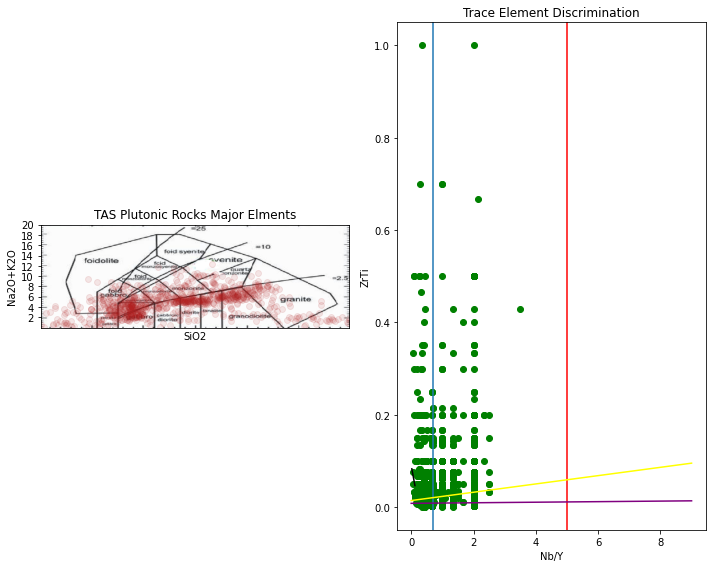

In [3]:
trace_df['Nb/Y'] = trace_df.apply(lambda row: row['nbppm_s']/row['yppm_s'], axis=1)
trace_df['Zr/Ti'] = trace_df.apply(lambda row: row['zrppm_s']/(row['tipct_s']*10000), axis=1)

win_img = plt.imread(r'/Users/michaelspehlmann/Documents/rock classer/winchester floyd.png')

x_bas_andbas = [i for i in range(10)]
y_bas_andbas = [0.008+((0.006/10)*i) for i in x_bas_andbas]

x_andbas_and = [i for i in range(10)]
y_andbas_and = [0.014+((0.09/10)*i) for i in x_andbas_and]

x_and_ryh = [0.02, 0.04, 0.06, 0.08, .1, .12]
y_and_ryh = [0.09+((-0.04/0.11)*i) for i in x_and_ryh]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
plt.setp(ax1, xticks=[1,2,3,4,5,6], xticklabels=[40,50,60,70,80,90], yticks=[2,4,6,8,10,12,14,16,18,20], yticklabels=[2,4,6,8,10,12,14,16,18,20])
ax1.scatter(major_df['sio2_xrf'], major_df['na2o+k2o'], alpha=0.1, c='firebrick')
ax1.imshow(tas_img, zorder=0, extent=[30,90,0,20])
ax1.set_title('TAS Plutonic Rocks Major Elments')
ax1.set(xlabel='SiO2', ylabel='Na2O+K2O')

#plt.setp(ax2, xticks=[0.1,1,10], xticklabels=[0.1, 1, 10], yticks=[0.01,0.1,1,10], yticklabels=[0.01,0.1,1,10])
ax2.scatter(trace_df['Nb/Y'], trace_df['Zr/Ti'], c='green')
#ax2.imshow(win_img, zorder=0, extent=[0.01,10,0.001,10])
ax2.set_title('Trace Element Discrimination')
ax2.axvline(0.7, label='subalk|alk')
ax2.axvline(5, c='red')
ax2.plot(x_andbas_and, y_andbas_and, c='yellow')
ax2.plot(x_bas_andbas, y_bas_andbas, c='purple')
ax2.plot(x_and_ryh, y_and_ryh, c='black')
ax2.set(xlabel='Nb/Y', ylabel='ZrTi')

fig.tight_layout()


So now that we have our discrimination plots finished it looks like there is a lot of different detection limits used in the trace elements plot.  Metadata will need to be explored to check that prep and analysis suites are the same.  For now we break out the based on these as this is just a fun project for me and I do too much data wrangling for work.

Text(0.5, 1.0, 'Count Plot of Different Protoliths')

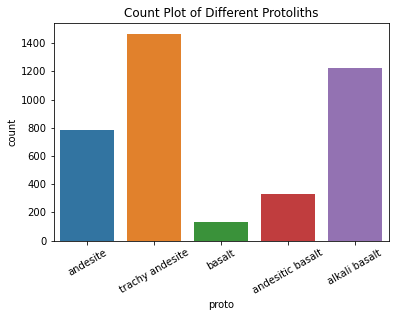

In [4]:
import seaborn as sns

def lith_classer(x, y):
    sub_alk = False
    if x <= 0.7:
        sub_alk=True
    if sub_alk == True:
        if y < 0.008+((0.006/10)*x):
            return 'basalt'
        elif y<0.014+((0.09/10)*x):
            return 'andesitic basalt'
        else:
            return 'andesite'
    if sub_alk == False:
        if y<0.014+((0.09/10)*x):
            return 'alkali basalt'
        else:
            return 'trachy andesite'
        
trace_df['proto'] = trace_df.apply(lambda row: lith_classer(row['Nb/Y'], row['Zr/Ti']), axis=1)


sns.countplot(x='proto', data=trace_df)
plt.xticks(rotation=30)
plt.title('Count Plot of Different Protoliths')
        

So now that we have our datalabeled we can begin building the k nearest neighbors model.  

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

rockclass_df = trace_df.drop(labels='lab_id', axis=1)
columns = (list(rockclass_df.columns))
data = rockclass_df.iloc[:,[i for i in range(72)]]
labels = rockclass_df.iloc[:,[72]]
data.fillna(0, inplace=True)
print(data.head())

train_set, test_set, train_labels, test_labels = train_test_split(data, labels, test_size=0.4, random_state=4)


x_plot = []
y_plot = []

for neighbor in range(1,101):
    classifier = KNeighborsClassifier(n_neighbors=neighbor)
    classifier.fit(train_set,train_labels)
    y = classifier.score(test_set, test_labels)
    x_plot.append(neighbor)
    y_plot.append(y)
    


/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/michaelspehlmann/opt

   alpct_s  capct_s  fepct_s  kpct_s  mgpct_s  napct_s  ppct_s  sipct_s  \
0      0.0      3.0      7.0     0.0     1.50      0.0     0.0      0.0   
1      0.0      0.7      1.5     0.0     0.07      0.0     0.0      0.0   
2      0.0      0.3      1.0     0.0     0.02      0.0     0.0      0.0   
3      0.0      7.0      5.0     0.0     1.00      0.0     0.0      0.0   
4      0.0      7.0     10.0     0.0     3.00      0.0     0.0      0.0   

   tipct_s  agppm_s  ...  uppm_s  vppm_s  wppm_s  yppm_s  ybppm_s  znppm_s  \
0     0.70      1.0  ...     0.0     300   100.0    30.0      0.0    200.0   
1     0.10      1.0  ...     0.0       7   100.0    10.0      0.0    200.0   
2     0.07      1.0  ...     0.0       7   100.0    10.0      0.0    200.0   
3     0.30      1.0  ...     0.0      70   100.0    20.0      0.0    200.0   
4     1.00      1.0  ...     0.0     500   100.0    30.0      0.0    200.0   

   zrppm_s  Unnamed: 139      Nb/Y     Zr/Ti  
0    200.0           0.0  0.33333

/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/michaelspehlmann/opt/anaconda3/envs/rock_class/lib/python3.8/site-packages/sklear

Now that we have fitted many different nearest neighbor models and tested their accuracy against our test data we can determine what number of neighbors is the best to make accurate protolith classifications.

(10, 0.5590851334180432)


Text(0, 0.5, 'accuracy')

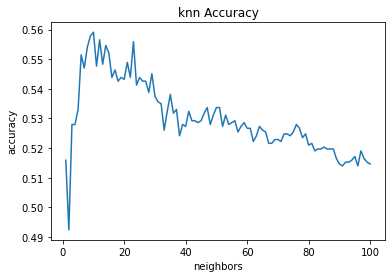

In [6]:

pts = list(zip(x_plot, y_plot))
seen = pts[1]
for pt in pts:
    if pt[1] > seen[1]:
        seen = pt

print(seen)
plt.plot(x_plot, y_plot)
plt.title('knn Accuracy')
plt.xlabel('neighbors')
plt.ylabel('accuracy')


So that is pretty disappointing that the accuracy of the classifier model only is about 56%.  What I should do to try and increase accuracy is check the data.  It is likely that there were several different detection limits being used in the USGS dataset.  The next set shoould be to go through the metadata and about lab analytics and be sure that the same lab suites are used for all observations that will be used to train and test the model.  

In [7]:
random_sel = np.random.choice(['heads', 'tails'], p=[0.5, 0.5])


NameError: name 'np' is not defined